## IVT De-Novo detection statistics


### Tombo: Extracting and Plotting Stats from yeast rRNA
For each read at each position, this method performs a hypothesis test against the canonical model based on the genomic sequence. 

Calculate z-score for each kmer covering a position and convert to p-value
Then use Fishers Method to aggregate p-values https://en.wikipedia.org/wiki/Fisher%27s_method

```
z_scores = np.abs(r_means - r_ref_means) / r_ref_sds
r_pvals = stats.norm.cdf(-z_scores) * 2.0
if fm_offset > 0:
    r_pvals = calc_window_fishers_method(r_pvals, fm_offset)
```
lower_thresh = 0.05, single_read_thresh = 0.4
If p value is below 0.05 it is modified and if it is above 0.4 it is canonical. 
RNA threshold defaults: (0.05, 0.4) (apply_per_read_thresh)


In [1]:
# Tombo library
from tombo import tombo_helper, tombo_stats, resquiggle
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
# py3helpers
from py3helpers.classification import ClassificationMetrics
from py3helpers.utils import merge_lists
from py3helpers.seq_tools import ReferenceHandler

# Other common libraries
import pandas as pd
from sklearn.utils import assert_all_finite
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc

import numpy as np
# built in library
import os


In [2]:
HOME = "/Users/andrewbailey/CLionProjects/rrna_analysis" 

In [5]:
ivt_tombo_denovo = os.path.join(HOME, "tombo/de_novo/ivt.de_novo_detect.tombo.stats")

output_mods = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/mod_files/yeast_18S_25S_modified.positions"


In [6]:
ts = tombo_stats.TomboStats(ivt_tombo_denovo)

In [7]:
for contig in ts:
    all_data = contig[4]
    position_fraction_modified = {x[2]: x[1] for x in all_data}
    break


In [8]:
for contig in ts:
    print(contig)

('RDN18-1', '+', 0, 10000, array([(0.39447732, 0.39207921,    3,   633, 0,   505),
       (0.5041876 , 0.50363331,    4,  2416, 0,  1789),
       (0.22759651, 0.22741898,    5, 11680, 0,  8702), ...,
       (0.88120322, 0.88119956, 1790, 86315, 0, 64924),
       (0.58735072, 0.58733495, 1791, 71182, 0, 52333),
       (0.5192091 , 0.51918939, 1792, 67306, 0, 48803)],
      dtype=[('damp_frac', '<f8'), ('frac', '<f8'), ('pos', '<u4'), ('cov', '<u4'), ('control_cov', '<u4'), ('valid_cov', '<u4')]))
('RDN18-1', '-', 0, 10000, array([(1.        , 1.        ,   7, 4, 0, 2),
       (1.        , 1.        ,   8, 4, 0, 3),
       (1.        , 1.        ,   9, 4, 0, 4),
       (0.6       , 0.33333333,  10, 4, 0, 3),
       (0.5       , 0.        ,  11, 4, 0, 2),
       (0.5       , 0.        ,  12, 4, 0, 2),
       (0.6       , 0.33333333,  13, 4, 0, 3),
       (0.75      , 0.5       ,  14, 4, 0, 2),
       (0.75      , 0.5       ,  15, 4, 0, 2),
       (0.75      , 0.5       ,  16, 4, 0, 2),
  

In [9]:
mods_data = {"RDN18-1": [], "RDN25-1": []}
with open(output_mods, 'r') as fh:
    for line in fh:
        split_line = line.split()
        contig = split_line[0]
        pos = int(split_line[1])
        strand = split_line[2]
        find = split_line[3]
        mods = split_line[4]
        mods_data[contig].append([pos, strand, find, mods])


<IPython.core.display.Javascript object>


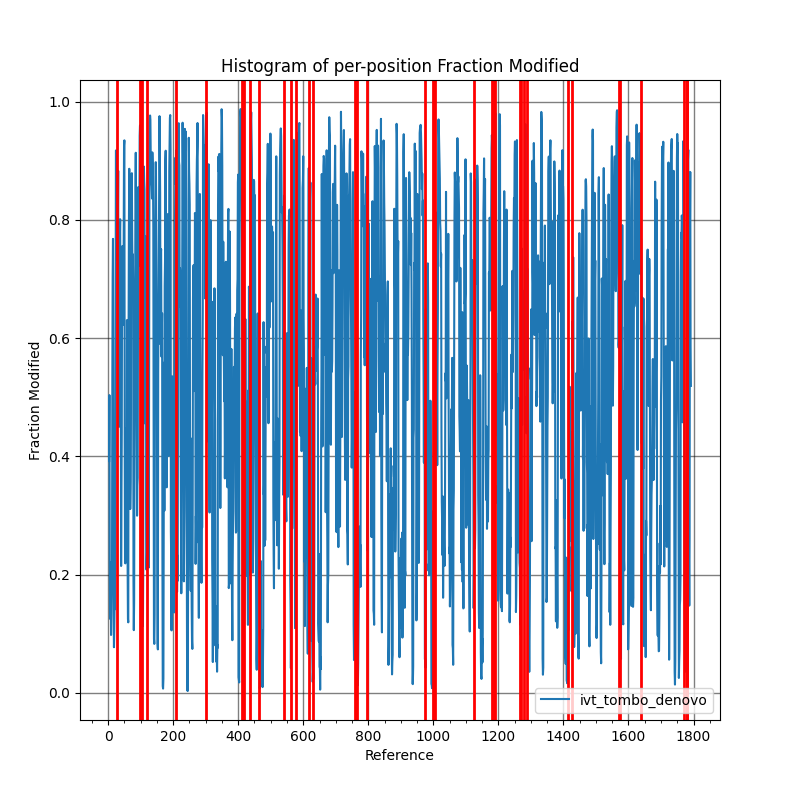

In [10]:
%matplotlib notebook
stats_files = [ivt_tombo_denovo]
labels = ["ivt_tombo_denovo"]
save_fig_path = None

title = "Histogram of per-position Fraction Modified"
y_label = "Reference"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("Fraction Modified")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

panel1.set_title(label=title)

for i in range(len(stats_files)):
    assert os.path.exists(stats_files[i])
    ts = tombo_stats.TomboStats(stats_files[i])
    for contig in ts:
        if contig[0] == "RDN18-1" and contig[1] == "+":
            all_data = contig[4]
            panel1.plot([x[2] for x in all_data], [x[1] for x in all_data], label=labels[i])

for mod in mods_data["RDN18-1"]:
    pos = mod[0]
    strand = mod[1]
    find = mod[2]
    mods = mod[3]
    panel1.axvline(x=pos, linewidth=2, color='r')
            
            
panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)


<IPython.core.display.Javascript object>


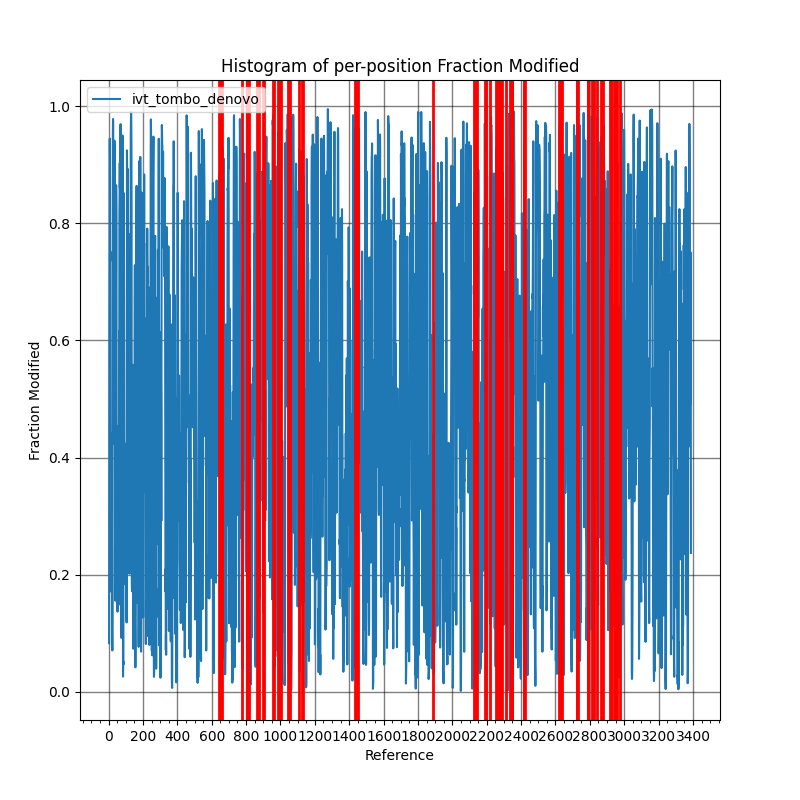

In [11]:
%matplotlib notebook
stats_files = [ivt_tombo_denovo]
labels = ["ivt_tombo_denovo"]
save_fig_path = None

title = "Histogram of per-position Fraction Modified"
y_label = "Reference"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("Fraction Modified")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

panel1.set_title(label=title)

for i in range(len(stats_files)):
    assert os.path.exists(stats_files[i])
    ts = tombo_stats.TomboStats(stats_files[i])
    for contig in ts:
        if contig[0] == "RDN25-1" and contig[1] == "+":
            all_data = contig[4]
            panel1.plot([x[2] for x in all_data], [x[1] for x in all_data], label=labels[i])

for mod in mods_data["RDN25-1"]:
    pos = mod[0]
    strand = mod[1]
    find = mod[2]
    mods = mod[3]
    panel1.axvline(x=pos, linewidth=2, color='r')
            
            
panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)


## Confirm Tombo de-novo is noisy for all reads


In [12]:
bed_file = "/Users/andrewbailey/CLionProjects/rrna_analysis/tombo/de_novo/mRNA_IVT/tombo_results.coverage.minus.bedgraph"

In [20]:
data = pd.read_csv(bed_file, sep="\t", skiprows=1, names=["gene", "start", "stop", "cov"])

In [31]:
ts = tombo_stats.TomboStats(ivt_tombo_denovo_mrna)
ivt_tombo_denovo_mrna = os.path.join(HOME, "tombo/de_novo/mRNA_IVT/ivt.de_novo_detect.tombo.stats")


In [32]:
test_gene = data[data["cov"] > 300]["gene"].iloc[0]


<IPython.core.display.Javascript object>


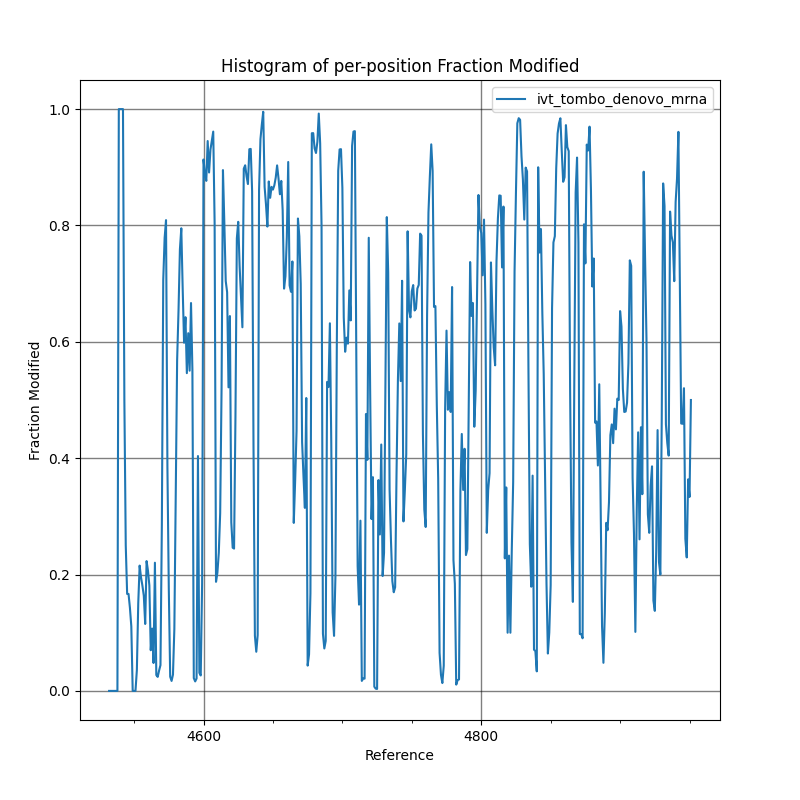

In [33]:
stats_files = [ivt_tombo_denovo_mrna]
labels = ["ivt_tombo_denovo_mrna"]
save_fig_path = None

title = "Histogram of per-position Fraction Modified"
y_label = "Reference"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("Fraction Modified")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

panel1.set_title(label=title)

for contig in ts:
    if contig[0] == test_gene and contig[1] == "-":
        all_data = contig[4]
        panel1.plot([x[2] for x in all_data], [x[1] for x in all_data], label=labels[i])

panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)